## Herso 1 sailing with the SL lighter
### Estimate Fuel use with vessel speed, h_0, current speed as input

- upstream 'Herso 1 + SL' longer formation
- downstream 'Herso 1 + SL' wider formation

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],
    [3.05674,0],
    [3.32804,0],
    [4.1148,0],
    [4.54888,0], 
    [4.73879,0],
    [5.07844,0],
    [6.62475,0], 
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 4.18, 4.18, 7.83, 7.5, 6.5, 10.6, 6.45, 8.04, 5.65, 8.87, 4.93, 7.7, 9.8, 5.45]
current_speeds = [-2.24* 0.2777,-3.4* 0.2777,-4.93* 0.2777,-2.59* 0.2777,-3.26* 0.2777,
                     -3.85* 0.2777,-1.87* 0.2777,-1.08* 0.2777,-2.83* 0.2777,-4.99* 0.2777,
                     -2.89* 0.2777,-6.4* 0.2777,-3.42* 0.2777,-1.64* 0.2777,-4.1* 0.2777]  # [m/s]

V_g_profile_up = [3.511429, 2.932533,2.507533, 3.417898,3.228096, 2.962490,3.646894,3.728326,3.366366, 2.719507,
3.351586,2.237576,3.186054,3.059887,2.915116] # [m/s] for upstream

V_g_profile_down = [4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 3.33, 4.44] # [m/s] for downstream

# power_applied = [620, 620, 620, 620, 620, 620, 620, 620, 620,620, 620, 620,620, 250, 620] ## [kW] for upstream
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

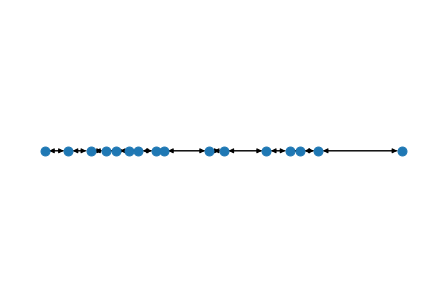

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 3.511429 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 3.511429 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.18 m
Current speed for edge ('Node 1', 'Node 2') is -0.94418 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 2.932533 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.18 m
Current speed for edge ('Node 2', 'Node 1') is -0.94418 m/

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 10.5,
    "L": 155.75,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000, # although the construction year of Herso 1 is 1961, checking with the SFC used in the paper,it is similar as year of 2000
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T":1.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.902, 
    "C_year": 2000,
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[15].name)
path_downstream = nx.dijkstra_path(FG, nodes[15].name, nodes[0].name)

### define simulation "Herso 1 sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation to get energy consumption

### upstream energy consumption

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
205.0 SFC final
214.92948475596245 SFC final
205.0 SFC final


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.4366 0),632.557163,780.0,2432.026643,4.985655e+05,0.643611,1.580817e+06,713.414968,22175.218930,193133.914249,176904.173556,2.516181,2.304737,4.835609e+05,4.429255e+05,1.140514,1.044673,4.812083e+05,1.134965,1.175751e+06,1.076949e+06,1.484274,1.359545,1.170031e+06,1.477053,1.258583e+06,1.152820e+06,2.048856,1.876683,1.252460e+06,2.038888,2.763667e+07,21.870743,1.520017
1,POINT (0.4366 0),POINT (0.8528 0),632.450212,780.0,2775.583012,5.689945e+05,0.734530,1.804129e+06,814.217231,25307.765902,220416.668945,201894.259790,2.871626,2.630313,5.518703e+05,5.054947e+05,1.301627,1.192247,5.491854e+05,1.295295,1.341842e+06,1.229082e+06,1.693948,1.551599,1.335314e+06,1.685706,1.436375e+06,1.315671e+06,2.338285,2.141790,1.429387e+06,2.326909,3.154072e+07,24.960279,1.734739
2,POINT (0.8528 0),POINT (1.1443 0),632.359006,780.0,2273.130244,4.659917e+05,0.601561,1.477535e+06,666.838668,20726.401566,180515.514884,165346.143885,2.351787,2.154158,4.519674e+05,4.139870e+05,1.065999,0.976419,4.497685e+05,1.060813,1.098934e+06,1.006586e+06,1.387299,1.270719,1.093587e+06,1.380550,1.176354e+06,1.077500e+06,1.914994,1.754070,1.170630e+06,1.905678,2.583103e+07,20.441819,1.420706
3,POINT (1.1443 0),POINT (1.31495 0),632.543672,780.0,976.576840,2.001983e+05,0.258441,6.347749e+05,286.471779,8904.427623,77552.648588,71035.619295,1.010369,0.925464,1.941732e+05,1.778561e+05,0.457972,0.419487,1.932285e+05,0.455744,4.721212e+05,4.324472e+05,0.596008,0.545923,4.698243e+05,0.593108,5.053822e+05,4.629131e+05,0.822715,0.753580,5.029235e+05,0.818713,1.109746e+07,8.782166,0.610361
4,POINT (1.31495 0),POINT (1.56274 0),632.513708,780.0,1501.329391,3.077725e+05,0.397312,9.758641e+05,440.407619,13689.121386,119224.689696,109205.808209,1.553279,1.422752,2.985099e+05,2.734251e+05,0.704058,0.644893,2.970577e+05,0.700633,7.258103e+05,6.648178e+05,0.916266,0.839269,7.222791e+05,0.911809,7.769437e+05,7.116543e+05,1.264792,1.158507,7.731638e+05,1.258639,1.706056e+07,13.501164,0.938331
5,POINT (1.56274 0),POINT (1.736384 0),632.477173,780.0,1146.347939,2.350013e+05,0.303369,7.451262e+05,336.278772,10452.400512,91034.637834,83384.668268,1.186015,1.086350,2.279288e+05,2.087751e+05,0.537587,0.492412,2.268199e+05,0.534972,5.541962e+05,5.076251e+05,0.699620,0.640828,5.515000e+05,0.696216,5.932394e+05,5.433874e+05,0.965739,0.884584,5.903532e+05,0.961040,1.302668e+07,10.308884,0.716467
6,POINT (1.736384 0),POINT (2.071 0),632.584043,780.0,1794.777044,3.679293e+05,0.474970,1.166605e+06,526.479340,16364.777091,142528.173698,130551.016245,1.856881,1.700841,3.568563e+05,3.268683e+05,0.841672,0.770943,3.551201e+05,0.837577,8.676761e+05,7.947621e+05,1.095358,1.003312,8.634548e+05,1.090029,9.288039e+05,8.507532e+05,1.512006,1.384947,9.242852e+05,1.504650,2.039519e+07,16.140081,1.121736
7,POINT (2.071 0),POINT (2.20665 0),632.602527,780.0,711.714069,1.459014e+05,0.188348,4.626141e+05,208.772972,6489.408883,56519.168663,51769.658691,0.736341,0.674464,1.415104e+05,1.296188e+

#### upstream_total_diesel_use [kg] of main engine

In [12]:
upstream_total_diesel_use = (df_upstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use

8550.687304872585

In [13]:
(upstream_total_diesel_use-8226)/upstream_total_diesel_use # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

0.03797207093370875

### downstream energy consumption

In [14]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_C_year_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

220.16801469665128 SFC final
232.40310851037952 SFC final
211.46269450933383 SFC final
235.1221389736275 SFC final
207.05 SFC final
227.18443374070634 SFC final
207.05 SFC final
209.1 SFC final
209.1 SFC final
214.21825404944403 SFC final
210.38009117116187 SFC final
205.5041018950307 SFC final
225.68319965408796 SFC final
212.2962527114943 SFC final
205.0 SFC final


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (6.62475 0),POINT (5.07844 0),304.218885,780.0,3276.185428,721311.241545,0.931160,2.287084e+06,1016.263202,31473.509052,232190.349067,225631.419280,3.025015,2.939564,581348.768716,564926.786619,1.371154,1.332422,696199.331652,1.642038,1.413517e+06,1.373588e+06,1.784431,1.734024,1.692770e+06,2.136961,1.513100e+06,1.470357e+06,2.463185,2.393605,1.812026e+06,2.949809,3.722938e+07,29.462099,2.047616
1,POINT (5.07844 0),POINT (4.73879 0),187.836285,780.0,592.428013,137682.111710,0.177737,4.365530e+05,201.341035,5943.869091,39534.735579,41906.819714,0.515065,0.545969,98985.465774,104924.593720,0.233465,0.247472,132888.812252,0.313428,2.406776e+05,2.551183e+05,0.303833,0.322063,3.231117e+05,0.407898,2.576334e+05,2.730914e+05,0.419403,0.444567,3.458750e+05,0.563052,6.732137e+06,5.327590,0.370268
2,POINT (4.73879 0),POINT (4.54888 0),423.051178,780.0,559.534001,118320.567530,0.152743,3.751628e+05,168.116244,5259.619610,41535.581302,39466.071602,0.541133,0.514171,103995.102056,98813.547696,0.245280,0.233059,114201.325712,0.269352,2.528583e+05,2.402596e+05,0.319210,0.303305,2.776742e+05,0.350537,2.706722e+05,2.571859e+05,0.440629,0.418675,2.972363e+05,0.483873,6.358341e+06,5.031781,0.349709
3,POINT (4.54888 0),POINT (4.1148 0),161.972337,780.0,489.661957,115130.366694,0.148625,3.650475e+05,173.234628,5034.910169,32676.807271,34637.415707,0.425719,0.451262,81814.863318,86723.755117,0.192966,0.204544,111122.189325,0.262090,1.989283e+05,2.108640e+05,0.251128,0.266196,2.701874e+05,0.341086,2.129428e+05,2.257194e+05,0.346651,0.367450,2.892221e+05,0.470827,5.564340e+06,4.403435,0.306039
4,POINT (4.1148 0),POINT (3.32804 0),513.954840,780.0,2816.131771,583080.083112,0.752713,1.848791e+06,836.391136,26159.715588,212827.593353,200211.253615,2.772754,2.608386,532869.087116,501280.807924,1.256811,1.182308,562780.587327,1.327360,1.295641e+06,1.218836e+06,1.635624,1.538665,1.368370e+06,1.727436,1.386920e+06,1.304703e+06,2.257776,2.123936,1.464771e+06,2.384512,3.200150e+07,25.324926,1.760082
5,POINT (3.32804 0),POINT (3.05674 0),237.477338,780.0,448.701690,101938.039359,0.131594,3.232182e+05,145.019281,4382.747029,30841.691070,29943.389389,0.401811,0.390108,77220.173883,74971.042605,0.182130,0.176825,98389.142972,0.232058,1.877565e+05,1.822879e+05,0.237025,0.230121,2.392277e+05,0.302002,2.009840e+05,1.951301e+05,0.327183,0.317654,2.560813e+05,0.416877,5.098883e+06,4.035087,0.280439
6,POINT (3.05674 0),POINT (2.20665 0),524.540004,780.0,3105.483765,642990.413619,0.830053,2.038750e+06,922.328678,28768.344774,238632.555310,222469.999632,3.108945,2.898377,597478.503145,557011.352461,1.409197,1.313753,620605.184610,1.463743,1.452736e+06,1.354342e+06,1.833940,1.709728,1.508967e+06,1.904927,1.555081e+06,1.449756e+06,2.531527,2.360067,1.615274e+06,2.629515,3.528959e+07,27.927012,1.940927
7,POINT (2.20665 0),POINT (2.071 0),1264.579462,780.0,736.885721,154082.804249,0.198910,4.885552e+05,214.433745,6718.924004,61468.612024,56059.374166,0.800823,0.730351,15

#### downstream_total_diesel_use [kg] of main engine

In [15]:
downstream_total_diesel_use = (df_downstream['total_diesel_consumption_C_year_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use

4125.469047999058

In [16]:
(4205-downstream_total_diesel_use)/4205 # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

0.018913424970497576

#### roundtrip_total_diesel_use [kg] of main engine

In [17]:
roundtrip_total_diesel_use = upstream_total_diesel_use + downstream_total_diesel_use
roundtrip_total_diesel_use

12676.156352871643

In [18]:
(12431-roundtrip_total_diesel_use)/12431 # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

-0.019721370193197918